In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from plottr.data.datadict_storage import datadict_from_hdf5
from plottr.data.datadict_storage import DataDict, DDH5Writer
import numpy as np
import matplotlib.pyplot as plt
import os
from pprint import pprint
from tqdm import tqdm

In [3]:
from measurement_codes_ut.measurement_tool.session import SessionManager as Session
from measurement_codes_ut.measurement_tool.datataking.continuous_wave import ContinuousWaveInstrumentManager as CW

In [4]:
session = Session(
    cooling_down_id='CDK136', 
    experiment_username="Watanabe", 
    sample_name="FTF2_jjver1_DB8")

In [5]:
cw = CW(session, save_path="../data/")

In [6]:
wiring = "\n".join([
    "readout",
    "M9804A_port1 - 1500mm - In2D",
    "Out2B - Miteq - 2000mm - M9804A_port2",
    
    "drive",
    "E8247C - 1500mm - 20dB - In1C",

    "local bias",
    "GS200 - DC C3"
])

cw.set_wiring_note(wiring)

In [7]:
cw.add_readout_line(
    port_name="readout",
    vna_address="TCPIP0::HAWAII::hislip_PXI0_CHASSIS1_SLOT10_INDEX0::INSTR"
)

# For qubit control line
cw.add_drive_line(
    port_name="qubit",
    lo_address="TCPIP0::192.168.100.7::inst0::INSTR",
    lo_power=0
)

cw.add_current_source_bias_line(
    port_name = "local_bias",
    current_source_address="TCPIP0::192.168.100.99::inst0::INSTR"
)

Connected to: YOKOGAWA GS210 (serial:90Y225046, firmware:2.02) in 0.04s


In [8]:
print(cw)

*** Allocated devices and channel assignemnt ***
device type          device name          device address                           port           
-----------------------------------------------------------------------------------------------
VNA                  M9804A               TCPIP0::HAWAII::hislip_PXI0_CHASSIS1_SLOT10_INDEX0::INSTR readout        
LO                   E8257D               TCPIP0::192.168.100.7::inst0::INSTR      qubit          
Current source       GS200                TCPIP0::192.168.100.99::inst0::INSTR     local_bias     


*** Current source status ***
port name            current (mA)        
----------------------------------------



In [9]:
exp_file = "cw_test.ipynb"

# Main

## One-tone

In [10]:
cw.port['readout'].frequency = np.linspace(6.37, 6.41, 1001) * 1e9
cw.port['readout'].power = -10 # dB
cw.port['readout'].device.if_bandwidth(100)
cw.port['qubit'].frequency = 10e9
cw.port['qubit'].power = 0
cw.port['local_bias'].current = 0

In [11]:
dataset = cw.take_data(dataset_name="OneTone", exp_file=exp_file)

Experiment id. 27 completed.


In [12]:
freq = dataset.data['VNA_frequency']['values']
cplx = dataset.data['S21']['values']

In [13]:
el_delay = 43.2e-9
cplx_cal = np.exp(1j*2*np.pi*freq*el_delay) * cplx

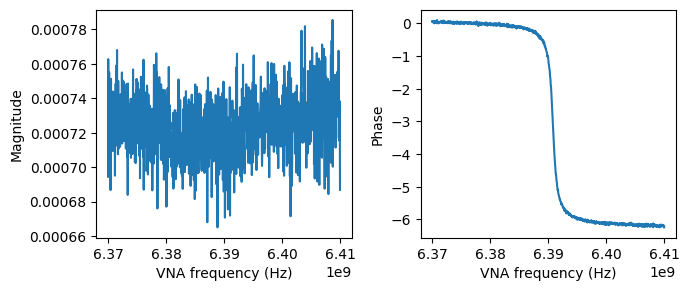

In [14]:
fig, ax = plt.subplots(1,2,figsize=(7,3))
ax[0].plot(freq, np.abs(cplx_cal))
ax[0].set_ylabel("Magnitude")
ax[1].plot(freq, np.unwrap(np.angle(cplx_cal)))
ax[1].set_ylabel("Phase")
fig.tight_layout()

for i in range(len(ax)):
    ax[i].set_xlabel('VNA frequency (Hz)')

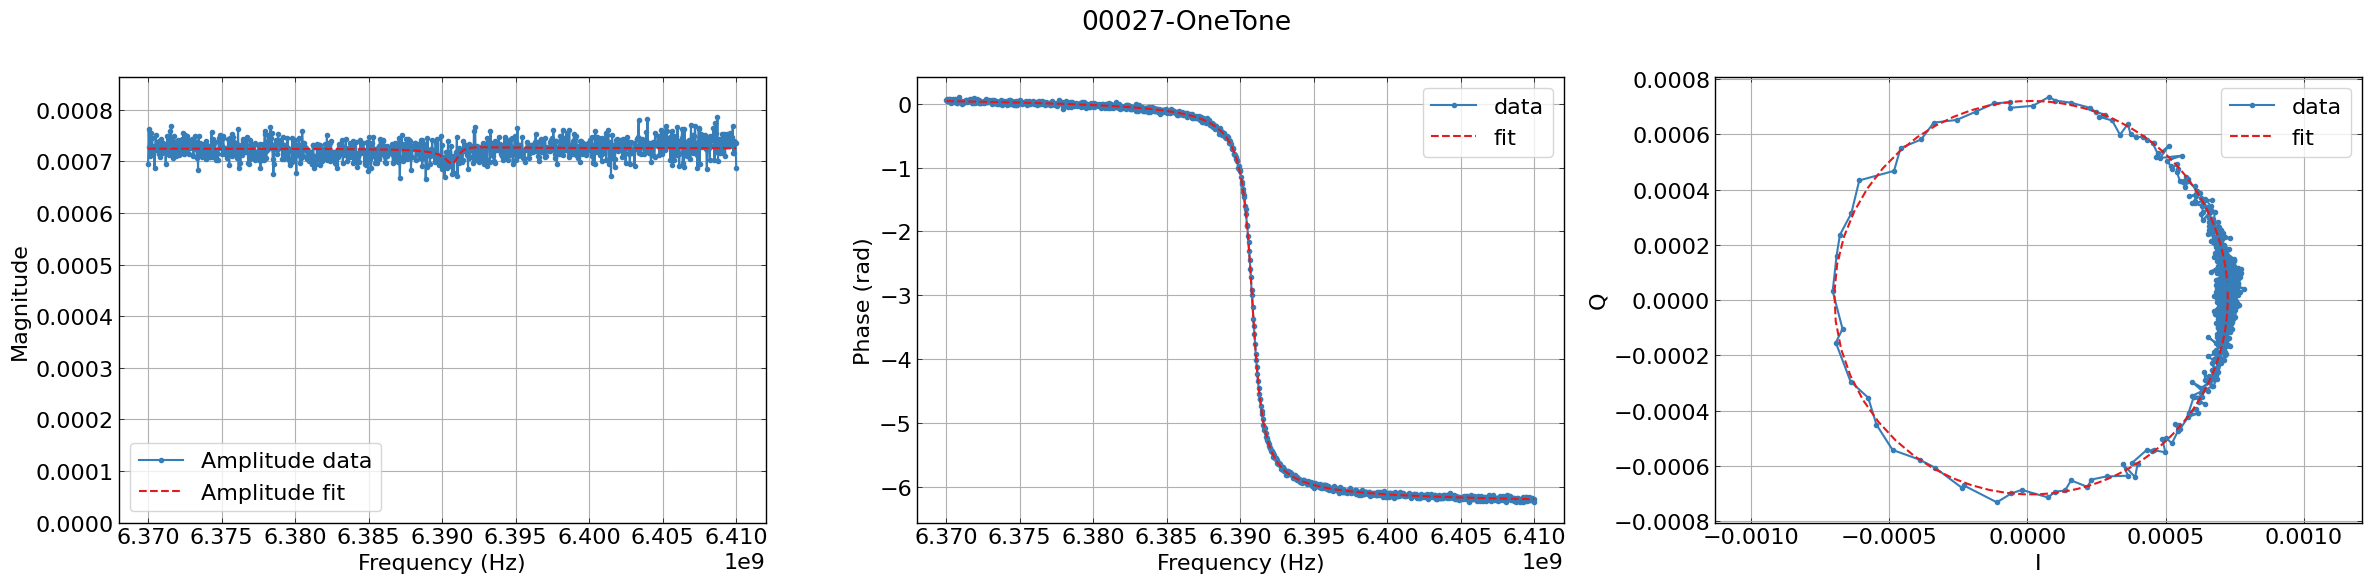

readout
M9804A_port1 - 1500mm - In2D
Out2B - Miteq - 2000mm - M9804A_port2
drive
E8247C - 1500mm - 20dB - In1C
local bias
GS200 - DC C3


In [15]:
from measurement_codes_ut.fitting import ResonatorReflectionModel
from measurement_codes_ut.helper.plot_helper import PlotHelper
model = ResonatorReflectionModel()
params = model.guess(
    cplx_cal, freq, electrical_delay_estimation="unwrap overcoupled")
rst = model.fit(cplx_cal, params=params, omega=freq)

fit_slice = 1001
freq_fit = np.linspace(min(freq), max(freq), fit_slice)
cplx_cal_fit = rst.eval(params=rst.params, omega=freq_fit)

data_label = dataset.path.split("/")[-1][27:]
plot = PlotHelper(f"{data_label}", 1, 3)
plot.plot_fitting(freq, np.abs(cplx_cal), y_fit=np.abs(
    cplx_cal_fit), label="Amplitude")
plot.label("Frequency (Hz)", "Magnitude")
plt.ylim(0, 1.1*np.max(np.abs(cplx_cal)))

plot.change_plot(0, 1)
plot.plot_fitting(freq, np.unwrap(np.angle(cplx_cal)),
                  y_fit=np.unwrap(np.angle(cplx_cal_fit)))
plot.label("Frequency (Hz)", "Phase (rad)")

plot.change_plot(0, 2)
plot.plot_complex(cplx_cal, fit=cplx_cal_fit)
plot.label("I", 'Q')

plt.tight_layout()
plt.show()
print(dataset.wiring_info)

In [16]:
rst.params

name,value,standard error,relative error,initial value,min,max,vary
omega_0,6.3908e+09,2073.49157,(0.00%),6390816881.038839,-inf,inf,True
kappa_ex,1074065.45,2992.16301,(0.28%),943334.4605624753,0.00000000,inf,True
kappa_in,20469.8599,2965.28687,(14.49%),125625.52827357617,0.00000000,inf,True
a,7.2514e-04,5.6572e-07,(0.08%),0.0007467124160613647,0.00000000,inf,True
tau,1.4893e-09,6.8105e-11,(4.57%),5.863010578613048e-10,-inf,inf,True
theta,3.29705878,0.43519042,(13.20%),-2.483532604885092,-inf,inf,True
phi,-0.01124790,0.00264448,(23.51%),-0.011736339336377744,-inf,inf,True
reflection_factor,1.00000000,0.00000000,(0.00%),1,-inf,inf,False


## One-tone power sweep

In [17]:
wiring = "\n".join([
    "readout",
    "M9804A_port1 - 1500mm - 10dB - 20dB - aIn2D",
    "Out2B - Miteq - 2000mm - M9804A_port2",
    
    "drive",
    "E8247C - 1500mm - 20dB - In1C",

    "local bias",
    "GS200 - DC C3"
])

cw.set_wiring_note(wiring)

In [19]:
cw.port['readout'].frequency = np.linspace(6.385, 6.395, 1001) * 1e9
cw.port['readout'].power = np.linspace(-60, 15, 20, dtype=int) # dB
cw.port['readout'].device.if_bandwidth(100)
cw.port['qubit'].frequency = 10e9
cw.port['qubit'].power = 0
cw.port['local_bias'].current = 0

dataset = cw.take_data(dataset_name="OneTone_power", exp_file=exp_file)

100%|██████████| 20/20 [03:17<00:00,  9.87s/it]

Experiment id. 17 completed.


In [20]:
freq = cw.port['readout'].frequency
power = cw.port['readout'].power
cplx = dataset.data['S21']['values']

In [30]:
plt.rcParams['font.size'] = 10

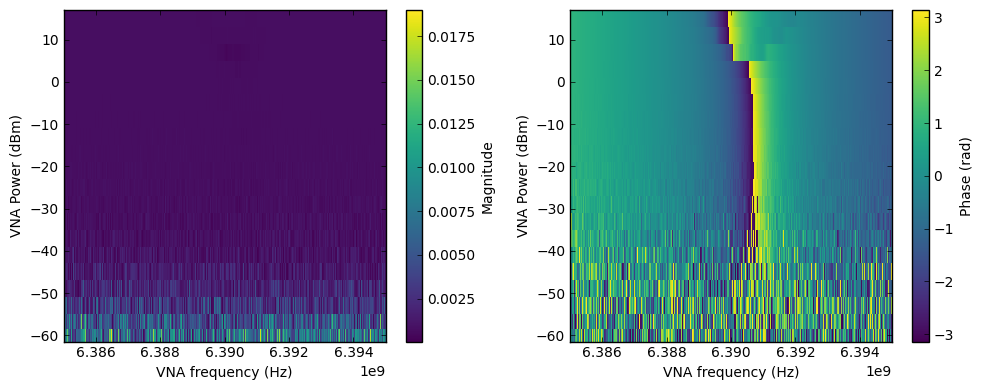

In [31]:
X, Y = np.meshgrid(freq, power)
fig, ax = plt.subplots(1, 2, figsize=(10,4))
mappable0 = ax[0].pcolormesh(X, Y, np.abs(cplx))
mappable1 = ax[1].pcolormesh(X, Y, np.angle(cplx))
cbar0 = fig.colorbar(mappable0, ax=ax[0])
cbar0.set_label("Magnitude")
cbar1 = fig.colorbar(mappable1, ax=ax[1])
cbar1.set_label("Phase (rad)")

for i in range(len(ax)):
    ax[i].set_ylabel("VNA Power (dBm)")
    ax[i].set_xlabel('VNA frequency (Hz)')
fig.tight_layout()

## One-tone bias sweep

In [42]:
cw.port['readout'].frequency = np.linspace(6.38, 6.40, 1001) * 1e9
cw.port['readout'].power = -10 # dB
cw.port['readout'].device.if_bandwidth(100)
cw.port['qubit'].frequency = 10e9
cw.port['qubit'].power = 0
cw.port['local_bias'].current = np.linspace(0, 2e-3, 101)

dataset = cw.take_data(dataset_name="OneTone_bias", exp_file=exp_file)

100%|██████████| 101/101 [32:45<00:00, 19.46s/it] 

Experiment id. 20 completed.


In [45]:
freq = cw.port['readout'].frequency
current = cw.port['local_bias'].current
cplx = dataset.data['S21']['values']

In [47]:
plt.rcParams['font.size'] = 10

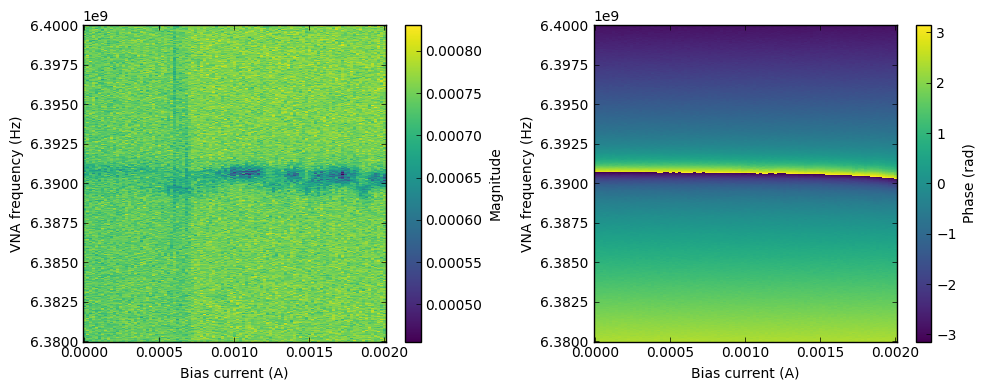

In [49]:
X, Y = np.meshgrid(current, freq)
fig, ax = plt.subplots(1, 2, figsize=(10,4))
mappable0 = ax[0].pcolormesh(X, Y, np.abs(cplx.T))
mappable1 = ax[1].pcolormesh(X, Y, np.angle(cplx.T))
cbar0 = fig.colorbar(mappable0, ax=ax[0])
cbar0.set_label("Magnitude")
cbar1 = fig.colorbar(mappable1, ax=ax[1])
cbar1.set_label("Phase (rad)")

for i in range(len(ax)):
    ax[i].set_xlabel("Bias current (A)")
    ax[i].set_ylabel('VNA frequency (Hz)')
fig.tight_layout()

In [57]:
cw.current_source.ramp_current(0, 1e-6,0.1)

In [56]:
cw.port['readout'].frequency = np.linspace(6.38, 6.40, 501) * 1e9
cw.port['readout'].power = -10 # dB
cw.port['readout'].device.if_bandwidth(100)
cw.port['qubit'].frequency = 10e9
cw.port['qubit'].power = 0
cw.port['local_bias'].current = np.linspace(-3e-3, 3e-3, 201)

dataset = cw.take_data(dataset_name="OneTone_bias", exp_file=exp_file)

 69%|██████▉   | 139/201 [15:25<06:52,  6.66s/it] 

KeyboardInterrupt



In [ ]:
freq = cw.port['readout'].frequency
current = cw.port['local_bias'].current
cplx = dataset.data['S21']['values']

In [ ]:
plt.rcParams['font.size'] = 10

In [ ]:
X, Y = np.meshgrid(current, freq)
fig, ax = plt.subplots(1, 2, figsize=(10,4))
mappable0 = ax[0].pcolormesh(X, Y, np.abs(cplx.T))
mappable1 = ax[1].pcolormesh(X, Y, np.angle(cplx.T))
cbar0 = fig.colorbar(mappable0, ax=ax[0])
cbar0.set_label("Magnitude")
cbar1 = fig.colorbar(mappable1, ax=ax[1])
cbar1.set_label("Phase (rad)")

for i in range(len(ax)):
    ax[i].set_xlabel("Bias current (A)")
    ax[i].set_ylabel('VNA frequency (Hz)')
fig.tight_layout()

## Two-tone at zero cuurrent

In [18]:
cw.port['readout'].frequency = 6.3908 * 1e9
cw.port['readout'].power = -10 # dB
cw.port['readout'].device.if_bandwidth(100)
cw.port['qubit'].frequency = np.arange(100, 10e3, 2)*1e6
cw.port['qubit'].power = [-25,-15,0]
cw.port['local_bias'].current = 0

dataset = cw.take_data(dataset_name="TwoTone_power_zerocurrent", exp_file=exp_file)

100%|██████████| 3/3 [02:24<00:00, 48.06s/it]

Experiment id. 28 completed.


In [23]:
cplx = dataset.data['S21']['values']
freq = dataset.data['LO_freq']['values'][0]
power = dataset.data['LO_power']['values']

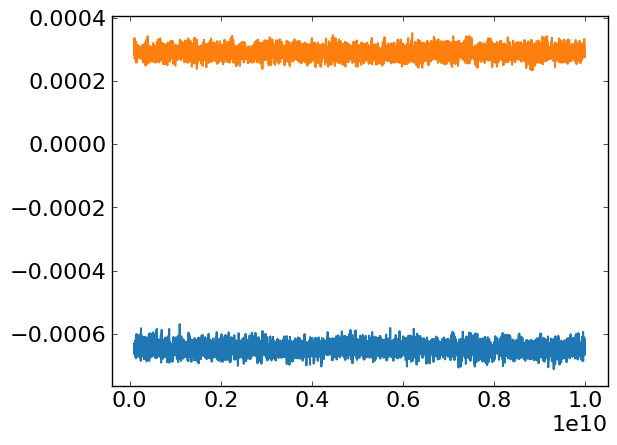

In [27]:
plt.plot(freq, cplx[0].real)
plt.plot(freq, cplx[0].imag)

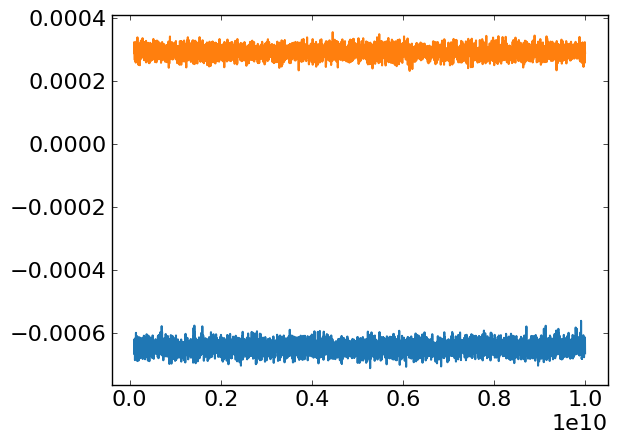

In [28]:
plt.plot(freq, cplx[1].real)
plt.plot(freq, cplx[1].imag)

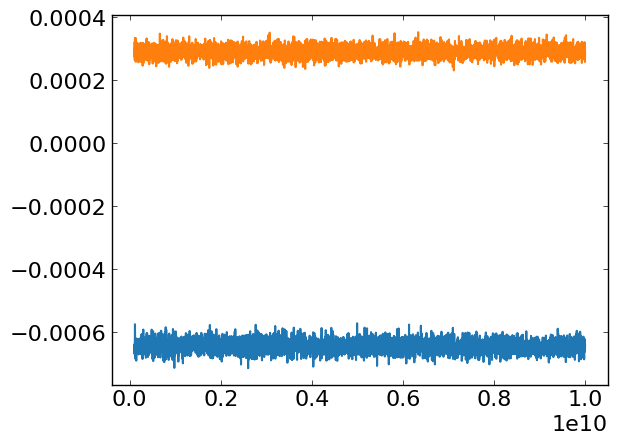

In [29]:
plt.plot(freq, cplx[2].real)
plt.plot(freq, cplx[2].imag)